# Timing

Timing in an experiment like NA62 is very different from other experiment such as LHC. For LHC experiments, the timing of the events is very well knows: one event comes every 25 ns. In NA62 we have a continuous beam of particle coming over periods of ~4.5 s (that we call burst or spill). During the burst we have about 750 MHz of particles entering the detector. Out of these, 6% are Kaons and only a fraction of them will decay in the fiducial decay volume. This means that every burst will see millions of Kaon decays and timing is therefore extremely important to be able to separate them. Different detectors will see different particle rates, but it is important to be able to consistently associate signals in time across all detectors, and therefore they should all have at least a resolution of the same order of magnitude. In the case of NA62, all detectors have a time resolution of better than ~1 ns.

The timing intervenes at multiple levels in NA62. The first level is the trigger. A clock signal is is distributed through the whole experiment with a period of approximately 25 ns (exactly: 24.951059536 ns). This period defines what we call a "frame" and it is used as a reference for the generated triggers. Once a trigger is generated and distributed to all detectors, they will send all the signals they acquired in the reference frame (and a couple of frames on either side to ensure we have all we need before throwing it away). After further processing the data are written on disk. This trigger period, or frame, therefore defines the time window of each event. Within this time window, each detector has a faster clock defining a finer time (generally of the order of few 100 of ps). This fine time is the one that we will really use to associate in time signals in different detectors.

However this reference fine time given by the trigger is not the most precise available. It is good enough for an initial association with the timing provided by detectors with more precise timing. But once done, or if you are also interested in events away from the trigger, it is better indeed to use for reference time one of those better timing. In these data, the reference fine time of the trigger is provided, but you also have available the time of the KTAG candidate closest to the time of your event (which may be in some cases the trigger reference fine time, the time of the event single track, or the average time of all the tracks in the event).

In this notebook we will investigate timing consideration. We have a few time variables in our data format and will we check how they correlate and how we can use it to remove spurious associations and reduce random veto (rejecting an event based on detector activity unrelated to the event of interest).

In [1]:
# As usual let's import all we need
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from na62 import prepare, hlf, extract, constants, stats
from lmfit import Model

**Exercise**: Knowing that Kaons in NA62 have energy of 75 GeV, what fraction of them will decay in the 80 m decay volume? How many decays is that over the 3 s period of a burst?

In [2]:
# Compute the fraction of Kaon decaying in the decay volume
p = 75000 # MeV
E = np.sqrt(p**2+constants.kaon_charged_mass**2) 
tau = 1.2380e-8 # Kaon lifetime
gamma = E/constants.kaon_charged_mass
length = 80
beam_rate = 750 # MHz
kaon_fraction = 0.06
burst_length = 3 # s

meanpath = constants.c*gamma*tau
# Which fraction will decay in the decay volume = decay probability in the given length
prob = 1 - np.exp(-length/meanpath)
decay_rate = beam_rate*1e6 * kaon_fraction * prob 
ndecays = decay_rate * burst_length

print(f"Kaon mean free path: {meanpath:.0f} m")
print(f"Probability of kaon decay within {length} m distance: {prob:.2%}")
print(f"Number of decays in the burst: {ndecays:.2}")

Kaon mean free path: 564 m
Probability of kaon decay within 80 m distance: 13.23%
Number of decays in the burst: 1.8e+07


**Exercise**: What is the maximum time resolution should we achieve to be able to distinguish individual events? Check the ideal case where the detector is sensitive to Kaon decays only. But some of the detectors are actually sensitive also to the full beam, which is the maximum time resolution in this case?

In [3]:
# The required time resolution to distinguish between two events is simply the time between two events
time_between_kaons = 1/decay_rate * 1e9 # In ns
time_between_beam = 1/(beam_rate * 1e6) * 1e9 # Beam rate in Hertz, then transform into ns

print(f"Average time between consecutive kaon decays: {time_between_kaons:.2f} ns")
print(f"Average time between consecutive beam particles: {time_between_beam:.2f} ns")

Average time between consecutive kaon decays: 168.00 ns
Average time between consecutive beam particles: 1.33 ns


In [4]:
# Let's read the data as usual
data, _ = prepare.import_root_files(["data/run12450.root"])

## Track - MUV3 timing
Let's first investigate the relationship between our track and the MUV3 signal. As you know, each track has a boolean variable indicating whether the track has MUV3 signal associated. However this association is spatial only, the timing is not considered. This means that a perfectly valid electron track may have a MUV3 (muon) signal associated. We know this is extremely unlikely that the electron itself leaves any signal on the MUV3. This situation can happen if a muon coming from the beam line hits the MUV3 at the same place as the electron would when we extrapolate its position on the MUV3. Given the rate of muons coming from the beam line, this situation is actually not unlikely. 

Let's take all the tracks that have MUV3 signal and look at the time difference between the track time and the MUV3 time:

In [5]:
# Extract all tracks with MUV3
all_tracks = extract.all_tracks(data)
all_tracks = all_tracks.loc[all_tracks["has_muv3"]]

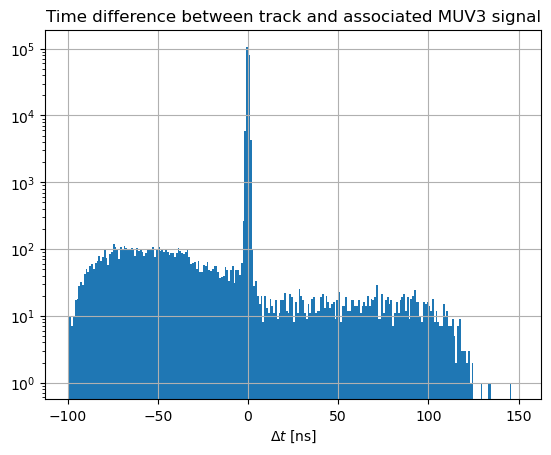

In [6]:
# And plot the time difference
(all_tracks["muv3_time"]-all_tracks["time"]).hist(bins=250, range=(-100, 150))
plt.title("Time difference between track and associated MUV3 signal")
plt.xlabel("$\Delta t$ [ns]")
plt.yscale("log")

This plot clearly shows a very large peak which corresponds to tracks where the MUV3 signal is related to the track. The width of this peak is related to the time resolution of the track and the MUV3. We have at a lower level, a flatish distribution of random association.  
We are now going to define an in-time MUV3 signal based on the resolution of this peak. Let's measure it:

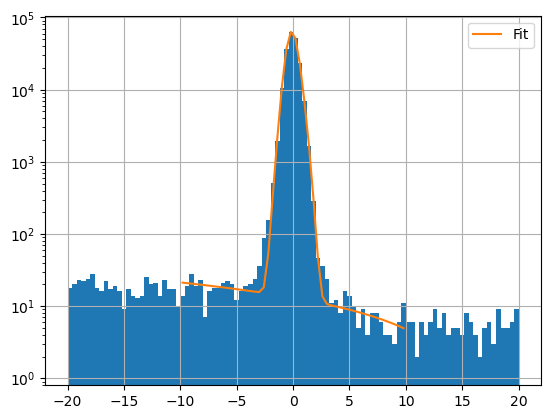

In [7]:
result = stats.perform_fit(all_tracks["muv3_time"]-all_tracks["time"], bins=100, display_range=(-20, 20), fit_range=(-10, 10), plot=True, model_wrapper=stats.gaussian2_uniform_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.8)
result

In [8]:
print(f"Measured time resolution: {result.params['m0_sigma'].value*1e3:.0f} +- {result.params['m0_sigma'].stderr*1e3:.0f} ps")

Measured time resolution: 413 +- 14 ps


From this we conclude that we have a time resolution of about 400 ps on the the MUV3 association with a track. To make sure we catch most associations correctly, we are in the future going to consider all MUV3 signal associated to a track if it is within 3$\sigma$\~1.5 ns to 5$\sigma$\~2.5 ns (depending whether we want to include or exclude MUV3 signal, and rounded for clarity)

## Event time
As mentioned in the introduction, we have two kind of time for the event:
 - The event time (timestamp) which represents the NA62 clock cycle (frame) from the beginning of the burst during which the event was acquired
 - The event fine time which represents the fine time of the trigger within this frame

Let's plot these two values, but transforming the event_time from units of frames to units of ns.

Text(0.5, 0, 'Event finetime [ns]')

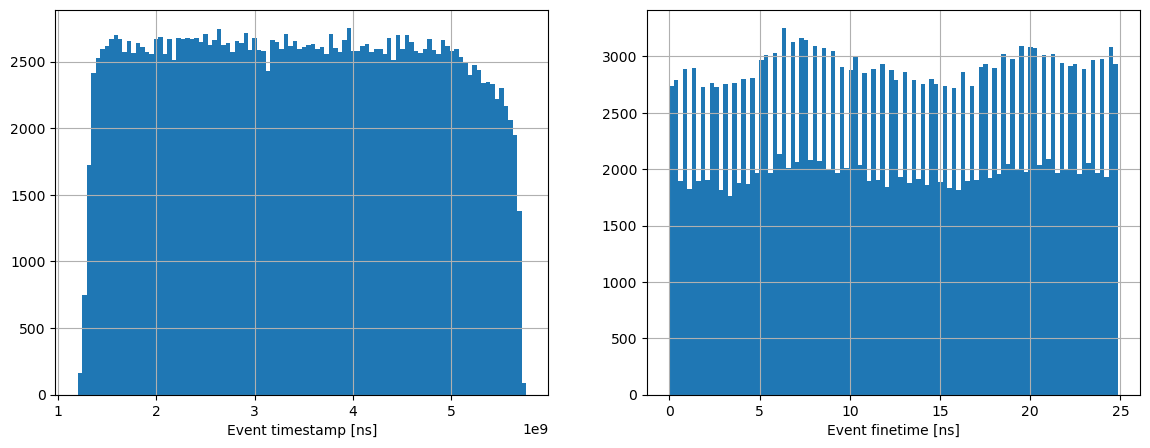

In [9]:
# Change the unit of event_time
data["event_time_ns"] = data["event_time"]*constants.clock_period

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
data["event_time_ns"].hist(bins=100, ax=ax[0])
ax[0].set_xlabel("Event timestamp [ns]")
data["reference_time"].hist(bins=100, ax=ax[1])
ax[1].set_xlabel("Event finetime [ns]")

We plot the event finetime naively but this results in a sawtooth profile. This is an artefact due to the fact that the finetime values are coming from digitizing electronics and are therefore already binned. With a naive plotting the digitized values are inconsistently grouped together. Instead if we use a compatible binning (where one is a multiple of the other), we obtain a nice profile.

reference_time
0.097465    109
0.097465     76
0.097465     41
0.097465     22
0.097465      2
0.097465      1
0.097465      1
0.097465      1
0.097465      1
0.097465      1
Name: count, dtype: int64

Text(0.5, 1.0, 'Event finetime - 256 bins of width 24.951059536/256')

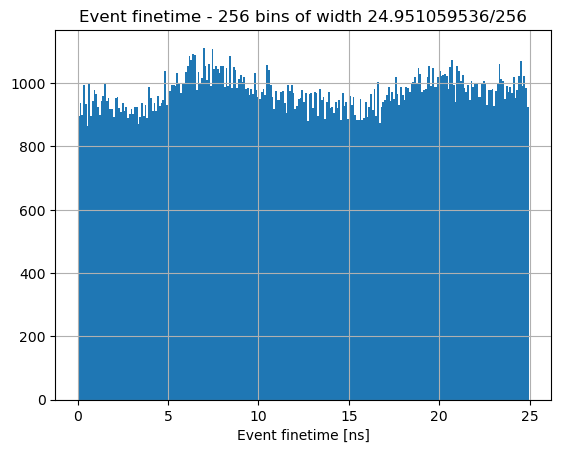

In [10]:
# The binning here is very important to avoid artefacts
# Compute the minimum time difference between consecutive fine time values (= electronics bin size)
#  - Take unique values/drop duplicate values (not interested in time difference of 0)
#  - Sort the values
#  - Take the difference between consecutive values
#  - Count the various time differences
time_diffs = data["reference_time"].drop_duplicates().sort_values().diff().value_counts()
# Display -> Same value displayed multiple times. This is a rounding issue, let's just take the first one
display(time_diffs)
bin_size = time_diffs.index[0]
nbins = int(constants.clock_period/bin_size)

data["reference_time"].hist(bins=nbins, range=(0, constants.clock_period))
plt.xlabel("Event finetime [ns]")
plt.title(f"Event finetime - {nbins} bins of width {constants.clock_period}/{nbins}")

The event time goes from ~1.2 s to ~5.7 s. As mentioned previously this corresponds to a burst. The accelerator complex runs what is called a "supercycle" during which the accelerators are filled, the beam accelerated and then extracted to experiments or larger accelerators several times. The destination of the beam from the SPS is different for each extraction and can include the North Area experiments (including NA62 - the beam is split between different targets in that case, each receiving a fraction of the intensity), the LHC, or some specific experiments requiring the whole beam intensity. The supercycle typically lasts between 35 s and 60 s, including one to three extractions to NA62 during the supercycle.

Before extracting to NA62, the accelerator complex sends a signal that the beam will be delivered, at which point the NA62 data acquisition electronics is activated. About 1.2 s later, the beam is sent to the experiment for a duration of 4.5 s before stopping. This process is repeated every 15 s to 40 s depending on the SPS supercycle. Each burst is acquired as a separate data file.

As written in the introduction, the triggers are generated based on the event time frame and data from 5 time frames are acquired for each event (two time frames surrounding the trigger time frame). Then at analysis level, we have access to a better timing, the finetime. As we discovered above the finetime is given in units of 1/256th of a frame, corresponding to a precision of ~97 ps.

In the following, let's have a look at the timing of our objects in the event (tracks and clusters) with respect to the fine time.

## Event - Track time

In [11]:
# Extract all tracks with MUV3
all_tracks = extract.all_tracks(data)
# Add the reference time and event_type to the tracks for convenience later
all_tracks = all_tracks.merge(data[["reference_time", "event_type"]], left_on="index", right_index=True)

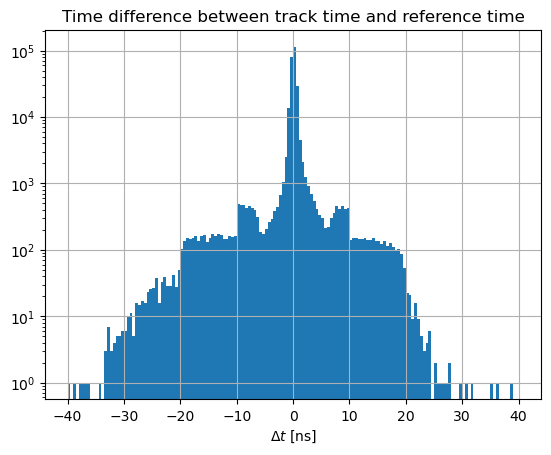

In [12]:
(all_tracks["time"] - all_tracks["reference_time"]).hist(bins=160, range=(-40, 40))
plt.yscale("log")
plt.title("Time difference between track time and reference time")
_ = plt.xlabel("$\Delta t$ [ns]")

The structure above looks quite complex, but this is due to the pre-selections that are applied to the events presented to you:
 - A hard cut at 10 ns from the trigger time
 - A soft cut at 20 ns from the trigger time
 - A depletion of events on either side of the central peak due to veto conditions in the one-track selections
Aside from this, we can however distinguish the important features of the well defined central peak corresponding to events where the track is the one that generated the trigger. We can confirm the special features by producing the same plot, but splitting by event_type

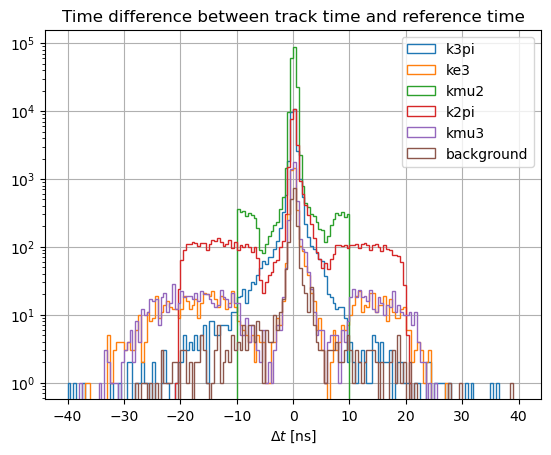

In [13]:
for event_type in constants.event_type_map:
    type_tracks = all_tracks.loc[all_tracks["event_type"]==constants.event_type_map[event_type]]
    (type_tracks["time"] - type_tracks["reference_time"]).hist(bins=160, range=(-40, 40), label=event_type, histtype="step")
    
plt.yscale("log")
plt.title("Time difference between track time and reference time")
plt.xlabel("$\Delta t$ [ns]")
_ = plt.legend()

This histogram clearly showcases the different features, which we will be able to understand later in the "event selection" notebook:
 - Hard cut at 10 ns is due to the kmu2 pre-selection
 - Soft cut at 20 ns is due to the k2pi pre-selection
 - All pre-selections but the k3pi features the depletion around the central peak

To complete this section, let's perform a fit of the resolution of the central peak

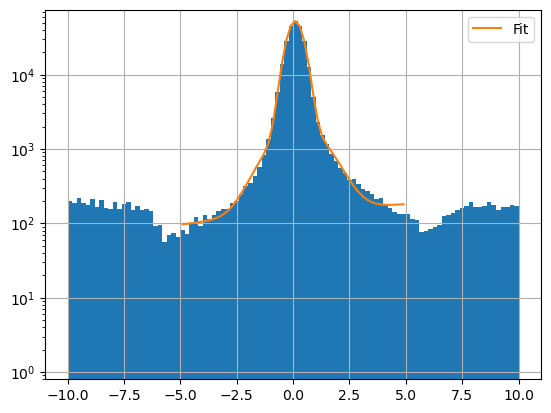

In [14]:
result = stats.perform_fit(all_tracks["time"]-all_tracks["reference_time"], bins=100, 
                           display_range=(-10, 10), fit_range=(-5, 5), plot=True, model_wrapper=stats.gaussian2_uniform_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.8)
result

In [15]:
print(f"Central peak resolution: $\sigma=${result.params['m0_sigma'].value:.3f} +- {result.params['m0_sigma'].stderr:.3f}")

Central peak resolution: $\sigma=$0.351 +- 0.003


The model does fit well in the tails due to the complex structure mentioned before, however the central peak looks alright and give us a resolution of ~350 ps.

## Event  - Cluster time

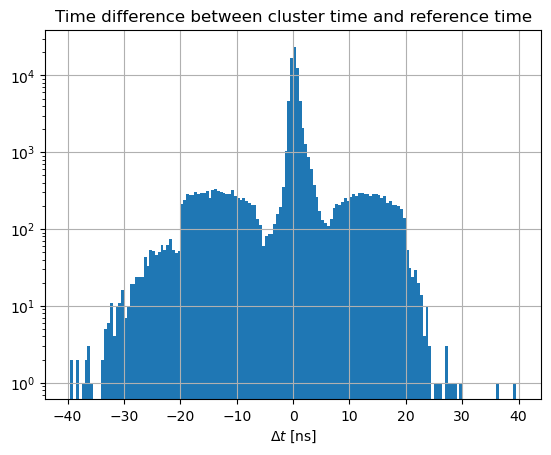

In [16]:
all_clusters = extract.all_clusters(data)
all_clusters = all_clusters.merge(data[["reference_time", "event_type"]], left_on="index", right_index=True)
(all_clusters["time"]-all_clusters["reference_time"]).hist(bins=160, range=(-40, 40))
plt.yscale("log")
plt.title("Time difference between cluster time and reference time")
_ = plt.xlabel("$\Delta t$ [ns]")

We can essentially see here similar features to what we saw with the tracks:
 - Depletion surounding the central peak due to veto conditions
 - Hard cut at 20 ns (cut in k2pi)

We can plot the features for each pre-selection as we did for the tracks to confirm the difference in k2pi with respect to the other selections.

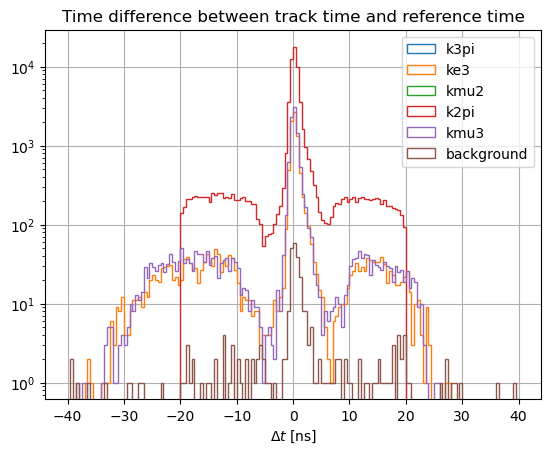

In [17]:
for event_type in constants.event_type_map:
    type_tracks = all_clusters.loc[all_clusters["event_type"]==constants.event_type_map[event_type]]
    (type_tracks["time"] - type_tracks["reference_time"]).hist(bins=160, range=(-40, 40), label=event_type, histtype="step")
    
plt.yscale("log")
plt.title("Time difference between track time and reference time")
plt.xlabel("$\Delta t$ [ns]")
_ = plt.legend()

And perform the fit:

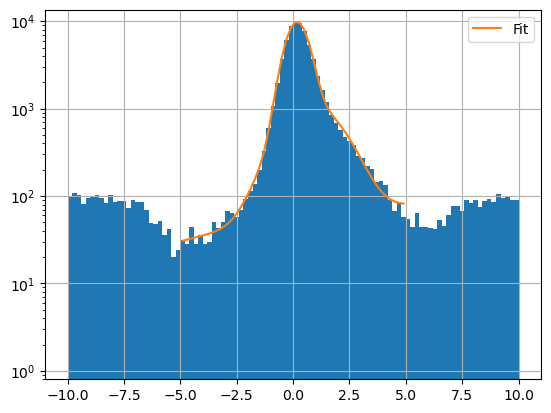

In [18]:
result = stats.perform_fit(all_clusters["time"]-all_clusters["reference_time"], bins=100, 
                           display_range=(-10, 10), fit_range=(-5, 5), plot=True, model_wrapper=stats.gaussian2_uniform_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.8)
result

In [19]:
print(f"Central peak resolution: $\sigma=${result.params['m0_sigma'].value:.3f} +- {result.params['m0_sigma'].stderr:.3f}")

Central peak resolution: $\sigma=$0.466 +- 0.006


## Event time - KTAG time
As mentioned in the introduction it may be better to use a more precise reference time instead of the trigger fine time. We shall investigate here the usage of the KTAG time instead.

First let's look at the difference between the event time and the KTAG time.

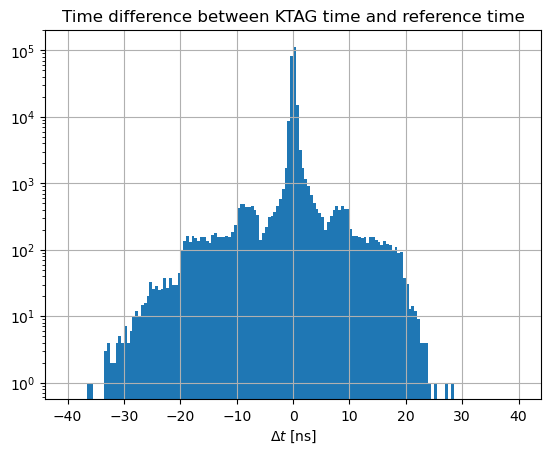

In [20]:
(data["ktag_time"] - data["reference_time"]).hist(bins=160, range=(-40, 40))
plt.yscale("log")
plt.title("Time difference between KTAG time and reference time")
_ = plt.xlabel("$\Delta t$ [ns]")

We see here very similar features to the ones we have seen in the time difference between the tracks or the clusters and the reference time, and for the same reasons that were already exposed.

But now we can use th KTAG time as reference and check the time difference distributions of the tracks and clusters with respect to the KTAG time.

In [21]:
# Extract all tracks with MUV3
all_tracks = extract.all_tracks(data)
# Add the reference time and event_type to the tracks for convenience later
all_tracks = all_tracks.merge(data["ktag_time"], left_on="index", right_index=True)

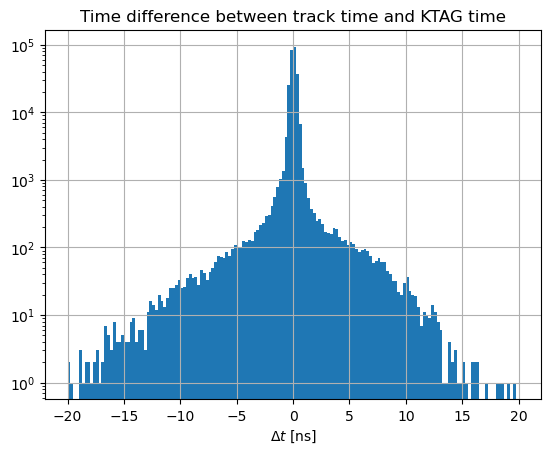

In [22]:
(all_tracks["time"] - all_tracks["ktag_time"]).hist(bins=160, range=(-20, 20))
plt.yscale("log")
plt.title("Time difference between track time and KTAG time")
_ = plt.xlabel("$\Delta t$ [ns]")

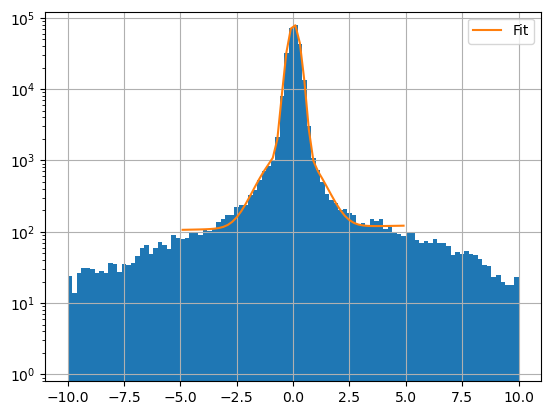

In [23]:
result = stats.perform_fit(all_tracks["time"]-all_tracks["ktag_time"], bins=100, 
                           display_range=(-10, 10), fit_range=(-5, 5), plot=True, model_wrapper=stats.gaussian2_uniform_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.8)
result

In [24]:
print(f"Central peak resolution: $\sigma=${result.params['m0_sigma'].value:.3f} +- {result.params['m0_sigma'].stderr:.3f}")

Central peak resolution: $\sigma=$0.240 +- 0.001


We reach here a time resolution on the central peak at 240 ps, which is ~30% better than the resolution we reached using the trigger reference time.

Let's do the same thing for clusters.

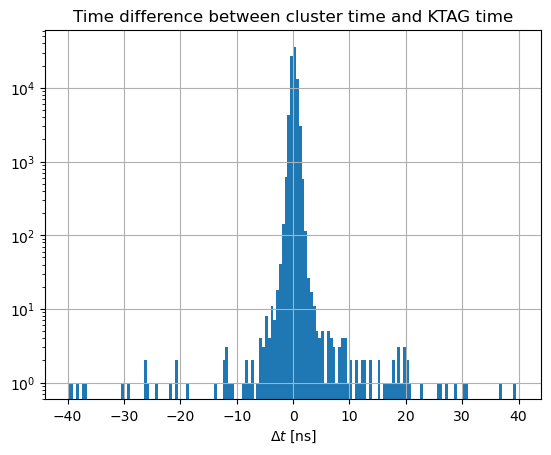

In [25]:
all_clusters = extract.all_clusters(data)
all_clusters = all_clusters.merge(data["ktag_time"], left_on="index", right_index=True)
(all_clusters["time"]-all_clusters["ktag_time"]).hist(bins=160, range=(-40, 40))
plt.yscale("log")
plt.title("Time difference between cluster time and KTAG time")
_ = plt.xlabel("$\Delta t$ [ns]")

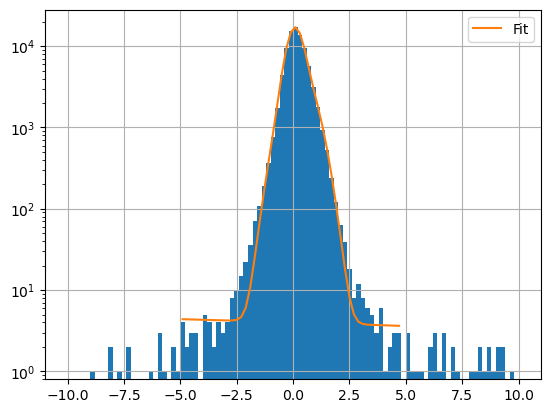

In [26]:
result = stats.perform_fit(all_clusters["time"]-all_clusters["ktag_time"], bins=100, 
                           display_range=(-10, 10), fit_range=(-5, 5), plot=True, model_wrapper=stats.gaussian2_uniform_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.8)
result

In [27]:
print(f"Central peak resolution: $\sigma=${result.params['m0_sigma'].value:.3f} +- {result.params['m0_sigma'].stderr:.3f}")

Central peak resolution: $\sigma=$0.318 +- 0.008


This shows a similar reduction in time resolution as for the tracks: ~30%

## Cluster - Track time
To conclude, we can look at the timing between the tracks and the clusters

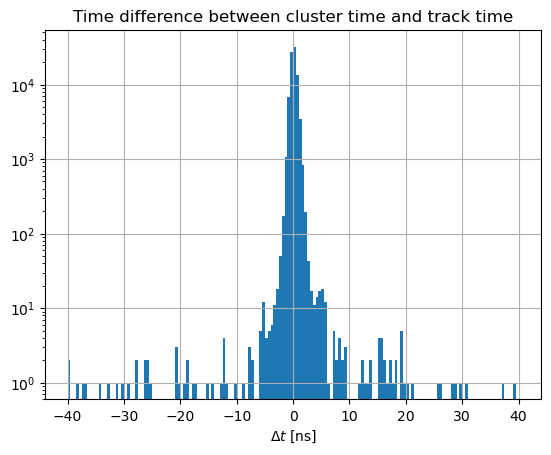

In [28]:
# Extract tracks and clusters
all_tracks = extract.all_tracks(data)
all_clusters = extract.all_clusters(data)

# We need to set the index to the same index to avoid mixing events
(all_clusters.set_index("index")["time"]-all_tracks.set_index("index")["time"]).hist(bins=160, range=(-40, 40))
plt.yscale("log")
plt.title("Time difference between cluster time and track time")
_ = plt.xlabel("$\Delta t$ [ns]")

In this case we see that the time difference is kept very small, probably with at cut at 6 ns. This explains also the soft cut at 20 ns that we see in the $\Delta t_\text{track,ref}$: the hard cut at 20 ns on $\Delta t_\text{cluster,ref}$ is convoluted with the hard cut at 6 ns on $\Delta t_\text{cluster,track}$.

Then let's perform the fit:

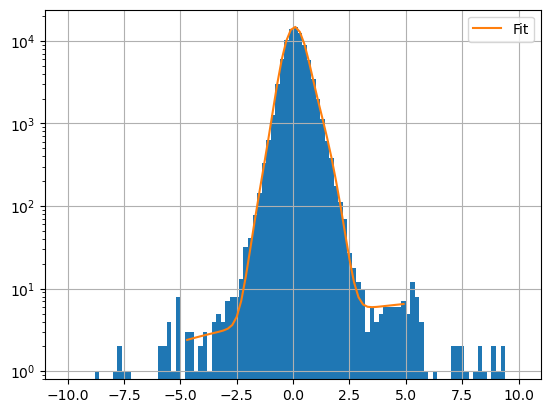

In [29]:
result = stats.perform_fit((all_clusters.set_index("index")["time"]-all_tracks.set_index("index")["time"]), bins=100, 
                           display_range=(-10, 10), fit_range=(-5, 5), plot=True, model_wrapper=stats.gaussian2_uniform_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.8)
result

In [30]:
print(f"Central peak resolution: $\sigma=${result.params['m0_sigma'].value:.3f} +- {result.params['m0_sigma'].stderr:.3f}")

Central peak resolution: $\sigma=$0.388 +- 0.006
